<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_chapter_BayesianOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ベイズ的最適化による実験計画法 (のノリ)

以下では、ベイズ的最適化を用いた実験計画法を見てみよう。

数学的部分やコードの詳細よりも「なんとなくこのあたりを探索しようかな」といった人間の経験に依る部分を客観的な方法で置き換えた実験計画の方法論の強力さを感じてもらうのが目的なので、難しいところはスキップしてOK。  
ガウス過程の基本や詳細は[講義ノート](https://drive.google.com/file/d/1ZKi8DJFSg00xir1IoEQiw3z9vxmejeCv/view)(7章)に譲る.



In [1]:
#使うライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import special

## データの生成用関数
def f(x):
    return np.sin(x) + 0.2 * x

## ガウス過程のカーネル(共分散行列)の設計
def Mat52(Thetas,r):
    tau,sigma = Thetas
    thetar = r * np.sqrt(5.0)/sigma
    return tau * (1.0 + thetar + (thetar**2) /3.0) * np.exp(-thetar)
def KernelMat(Thetas,xt,xp):
    lt = len(xt); lp=len(xp)
    Ktt = np.zeros((lt,lt)); Kpt = np.zeros((lp,lt));  Kpp = np.zeros((lp,lp))
    for j in range(lt):
        for i in range(j,lt):
            r = abs(xt[i]-xt[j])
            tmp  = Mat52(Thetas,r) 
            Ktt[i,j] = tmp; Ktt[j,i] = tmp 
        for i in range(lp):
            r= abs(xp[i]-xt[j])
            Kpt[i,j] = Mat52(Thetas,r)
    for j in range(lp):
        for i in range(j,lp):
            r= abs(xp[i]-xp[j])
            tmp  = Mat52(Thetas,r)
            Kpp[i,j] = tmp; Kpp[j,i] = tmp
    return Ktt,Kpt,Kpp

## 事後共分散行列の計算
def calcSj(cLinv,Kpt,Kpp,yt,mu_yt,mu_yp):
    tKtp= np.dot(cLinv,Kpt.T)
    return mu_yp + np.dot(Kpt,np.dot(cLinv.T,np.dot(cLinv,yt-mu_yt))), Kpp - np.dot(tKtp.T,tKtp)

## Cholesky分解
def Mchole(tmpA,ln) :
    cLL = np.linalg.cholesky(tmpA)
    logLii=0.0
    for i in range(ln):
        logLii += np.log(cLL[i,i])
    return np.linalg.inv(cLL), 2.0*logLii

## 獲得関数を計算, 次点の計算点を決める

def calcEI(xp,mujoint,sigmaj,xbest,ybest):
    EIs = [ (mujoint[i]-ybest) * Phi((mujoint[i]-ybest)/sigmaj[i]) +
            sigmaj[i]* np.exp(-0.5* ((mujoint[i]-ybest)/sigmaj[i])**2) for i in range(len(xp))]
    xnew,ynew,ind=xybest(xp,EIs)
    ynew= np.sin(xnew) + 0.2*xnew #+ 0.01 * (0.5-np.random.rand())
    return xnew,ynew,EIs,ind
def Phi(z):
    return 0.5 * special.erfc(-(z/(2**0.5)) )

def xybest(xt,yt):
    ind = np.argmax(yt)
    return xt[ind],yt[ind],ind

## お絵かき
def plotGP0(xt,yt,xp,ytrue):
    fig = plt.figure(figsize=(8,4))
    axT = fig.add_subplot(1,1,1)
    axT.set_xlabel("x"); axT.set_ylabel("y")
    axT.set_xlim(-2.0,12); axT.set_ylim(-2.0,5.0)
    axT.scatter(xt,yt,marker="o",color="black",label="Data")
    axT.plot(xp,ytrue,color="red",label="True",linestyle="dotted")
    axT.legend(loc="upper right")
    plt.show()
    #plt.savefig("BayesOpt_initial.pdf",bbox_inches="tight", pad_inches=0.1)
    plt.close()

def plotGP(nxt,nyt,nxp,xp,ytrue,mujoint,sigmaj,ysamples,EIs):
    fig = plt.figure(figsize=(16,4))
    axT = fig.add_subplot(121)
    axB = fig.add_subplot(122)
    axT.set_xlabel("x"); axT.set_ylabel("y")
    axB.set_xlabel("x"); axB.set_ylabel("Acquisition function")
    axT.set_xlim(-2.0,12); axT.set_ylim(-2.0,5.0)
    axB.set_xlim(-2.0,12)
    axT.scatter(nxt,nyt,marker="o",color="black",label="Data")
    for i in range(len(ysamples)):
        axT.plot(nxp,ysamples[i],alpha=0.1)
    axT.plot(nxp,mujoint,label="GP mean",linestyle="dashed",color="blue")
    axB.plot(nxp,EIs,color="green")
    axB.set_yticklabels([]) 
    axT.fill_between(nxp,mujoint-sigmaj,mujoint+sigmaj,color="blue", alpha=0.3)
    axT.plot(xp,ytrue,color="red",label="True",linestyle="dotted")
    axT.legend(loc="upper right")
    plt.show()
    plt.close()


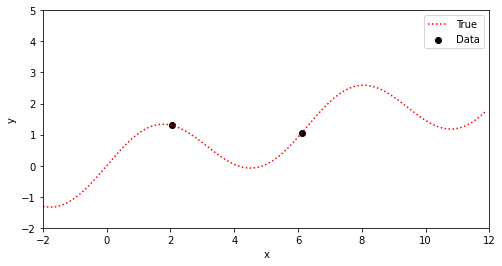

In [2]:
Thetas=[2.0,2.0]
oxt = np.array([ 0.0 + 1.02*i for i in range(11)])
xp = []
for tmp in np.arange(-2.0,12.0,0.1):
    if (tmp in oxt)==False:
        xp += [ tmp ]
xp = np.array(xp)
oyt = f(oxt)
ytrue = f(xp)

SVs=[]
xt =[oxt[2],oxt[6]]; yt =[oyt[2],oyt[6]]
plotGP0(xt,yt,xp,ytrue)

一般には真の関数(赤色)は分からないので、勾配も計算できない。  
数値的に勾配を計算するには、各点で微小にxをずらした場合の観測が必要、  
さらに、学習率を変えながら適当な値を探索するというのは、  
１回のデータの観測(測定,取得,計算, etc.)コストが高い場合はあまり良い方策ではない。  
([学習率]最適化の章を参照)

仮に勾配の計算ができたとしても、  
このデータの様に背後にある真の関数が多峰的(multimodal)な場合、  
勾配のみに基づく単純な最適化手法では局所解に停留する危険もある。

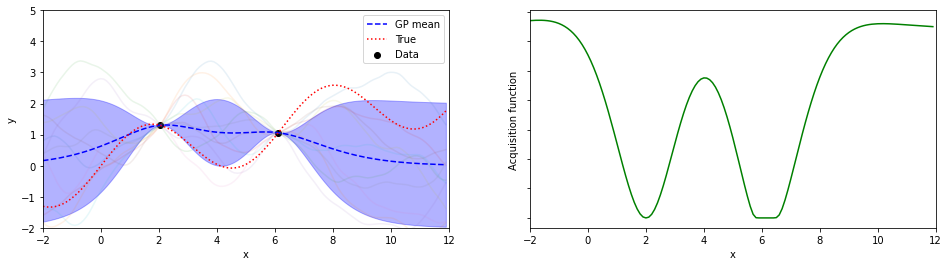

0 -1.6999999999999997 -1.3316648104524687


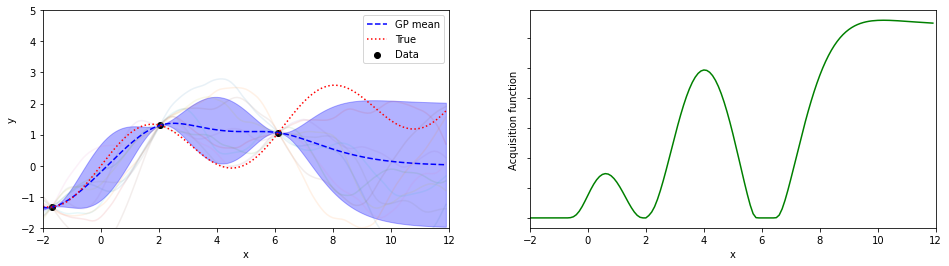

1 10.20000000000001 1.3401253124064523


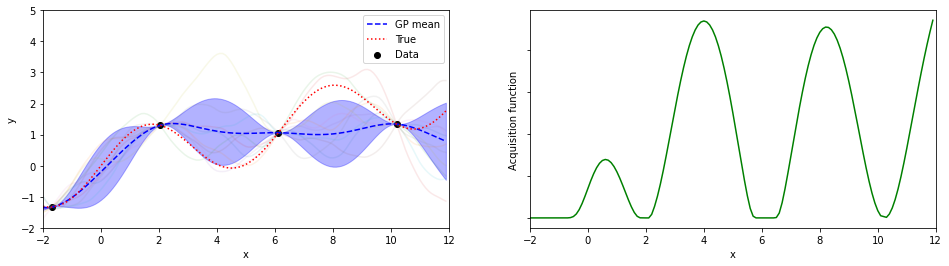

2 11.900000000000013 1.761862887762979


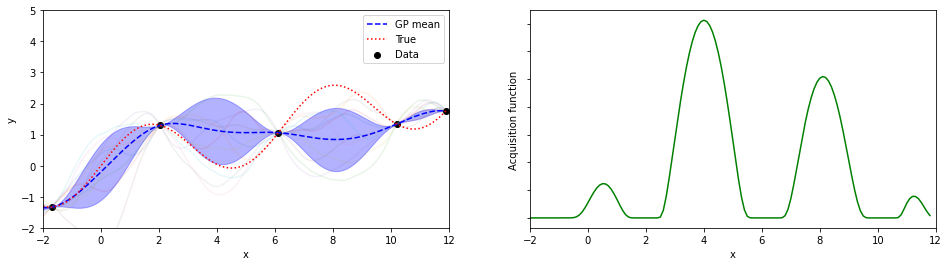

3 11.900000000000013 1.761862887762979


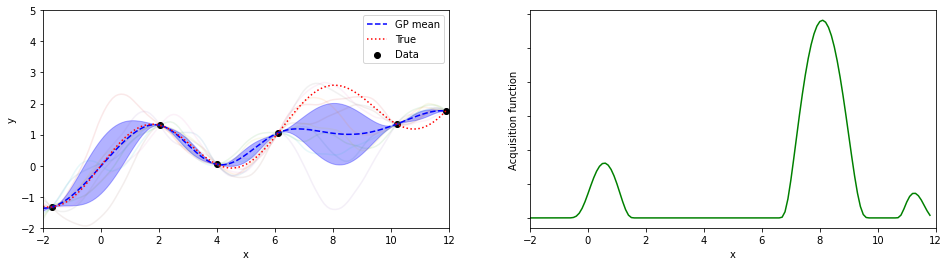

4 8.100000000000009 2.589889810845086


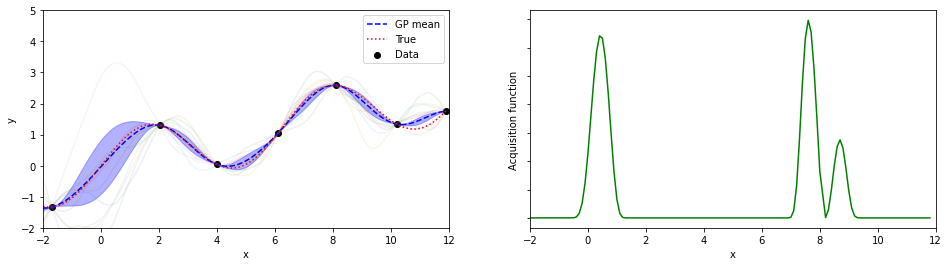

5 8.100000000000009 2.589889810845086


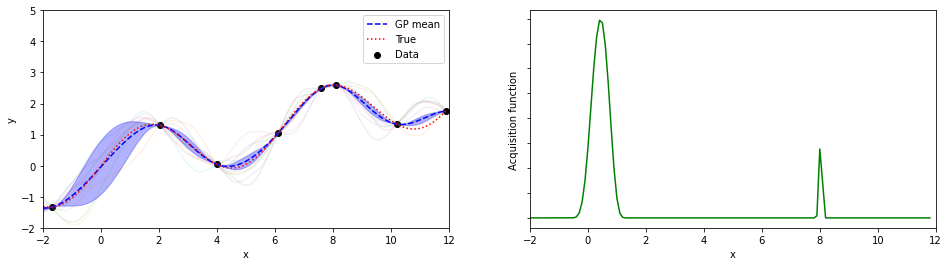

6 8.100000000000009 2.589889810845086


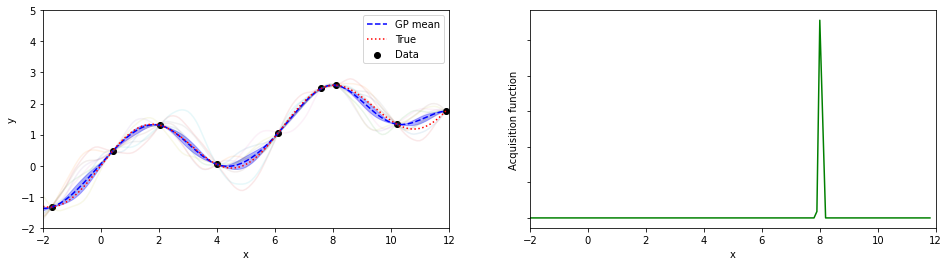

7 8.100000000000009 2.589889810845086


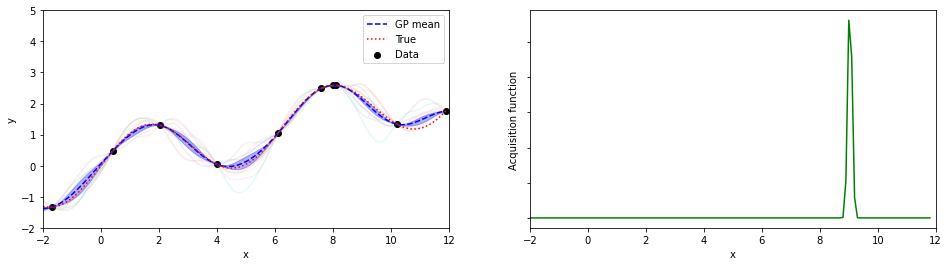

8 8.100000000000009 2.589889810845086


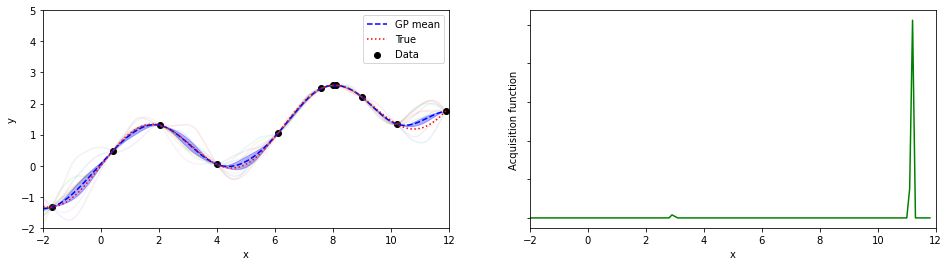

9 8.100000000000009 2.589889810845086


In [3]:
Thetas=[2.0,2.0]
nxp = list(copy.copy(xp))
nxt = copy.copy(xt)
nyt = copy.copy(yt)

n_iter = 10 ## 探索回数の上限
xopt = 6; yopt = -1.e+30
SVs=[]
plot = True
#plot = False

for iter in range(n_iter):
    lt=len(nxt); lp=len(nxp)
    Ktt,Kpt,Kpp = KernelMat(Thetas,nxt,nxp)
    mu_yt= np.array([ 0.0 for i in range(lt)])
    mu_yp= np.array([ 0.0 for i in range(lp)])
    cLinv,logdetK = Mchole(Ktt,lt) 
    mujoint,Sjoint = calcSj(cLinv,Kpt,Kpp,nyt,mu_yt,mu_yp)
    sigmaj=[ Sjoint[j][j] for j in range(lp)]
    ysamples = [np.random.multivariate_normal(mujoint,Sjoint) for i in range(10)]
    SVs += [ [ mujoint, sigmaj] ]
    xbest,ybest,ind= xybest(nxt,nyt)
    xnew,ynew,EIs,ind = calcEI(nxp,mujoint,sigmaj,xbest,ybest)
    if plot :
        plotGP(nxt,nyt,nxp,xp,ytrue,mujoint,sigmaj,ysamples,EIs)
    nxt += [ xnew ]; nyt += [ ynew ]
    nxp.pop(ind)    
    if ynew > yopt:
        xopt= xnew; yopt = ynew 
    print(iter, xopt, yopt)


探索点が増えるにつれて、効率的に最適解が探索出来ている(っぽい)。

4回目の探索でx=8.1が探索されていて、  
真の解8.055...にそこそこ近いものが得られている。

同じデータで、勾配法による最適化もやってみる。

In [4]:
import numpy as np 

def f(x):
    return np.sin(x) + 0.2 * x 
def derf(x):
    return np.cos(x) + 0.2  

xexact = 8.055339554764814

x = 6 
xopt = x; yopt=f(x)
tol = 1.e-1
eta = 1.e-1

itnum = 10**4
for i in range(itnum):
    x += eta * derf(x)
    y = f(x)
    if y > yopt:
        xopt = x
        yopt = y 
    if abs(xexact-xopt) < tol :
        break
print("探索回数",i, "最適解(x,y)=",xopt,yopt)

探索回数 31 最適解(x,y)= 7.959335108903231 2.586322475695181


$\eta$を適切に選べれば、より少ない探索回数でより正確な解が求まるが、  
そんなことができたら苦労はしない...。

また今の場合、勾配は式から計算したが、  
実際には差分をとって微分を近似することになるため  
探索回数は少なくとも2倍-3倍程度必要になる。

**言及しなかった重要な事項**

* カーネル関数の選択と依存性
* ハイパーパラメータの最適化 or サンプリング
* 獲得関数の定義・選択と依存性
* 数値計算(とくにガウス過程の部分)のTips

#### 備忘録: ライブラリの出力に関して

In [31]:
Thetas=[1.0,1.0]
nxp = np.linspace(-2,12,10)
nxt = copy.copy(xt);nyt = copy.copy(yt)

n_iter = 10 ## 探索回数の上限
xopt = 6; yopt = -1.e+30
SVs=[]
plot = False

lt=len(nxt); lp=len(nxp)
Ktt,Kpt,Kpp = KernelMat(Thetas,nxt,nxp)
mu_yt= np.array([ 0.0 for i in range(lt)])
mu_yp= np.array([ 0.0 for i in range(lp)])
cLinv,logdetK = Mchole(Ktt,lt) 
mujoint,Sjoint = calcSj(cLinv,Kpt,Kpp,nyt,mu_yt,mu_yp)
sigmaj=[ Sjoint[j][j] for j in range(lp)]
print("train", nxt,nyt)
print("xp", nxp)
print("My muj ", mujoint)

train [2.04, 6.12] [1.2999286509533796, 1.061537984784846]
xp [-2.         -0.44444444  1.11111111  2.66666667  4.22222222  5.77777778
  7.33333333  8.88888889 10.44444444 12.        ]
My muj  [5.75795234e-03 8.44113811e-02 7.33727607e-01 9.88413223e-01
 3.06567459e-01 9.73202438e-01 4.32586459e-01 4.31993679e-02
 2.79241473e-03 1.47812049e-04]


In [33]:
from sklearn.gaussian_process import kernels as sk_kern
import sklearn.gaussian_process as skGP 
# sklearn GP

nxp = np.linspace(-2,12,10)
nxt = np.array(copy.copy(xt))
nyt = np.array(copy.copy(yt))

kern = sk_kern.Matern(length_scale=1.0, length_scale_bounds=(1.0,1.0), nu=2.5)
sGP = skGP.GaussianProcessRegressor(
        kernel=kern,
        alpha=1e-15, 
        optimizer="fmin_l_bfgs_b", 
        n_restarts_optimizer=0)

sGP.fit(nxt.reshape(-1, 1), nyt)
print("sGP.kernel_", sGP.kernel_)
pred_mean, pred_std= sGP.predict(nxp.reshape(-1,1), return_std=True)

print(pred_mean)



sGP.kernel_ Matern(length_scale=1, nu=2.5)
[5.75795234e-03 8.44113811e-02 7.33727607e-01 9.88413223e-01
 3.06567459e-01 9.73202438e-01 4.32586459e-01 4.31993679e-02
 2.79241473e-03 1.47812049e-04]


In [ ]:
!pip install GPy

In [42]:
import GPy

nxp = np.linspace(-2,12,10).reshape(-1,1)
nxt = np.array(copy.copy(xt)).reshape(-1,1)
nyt = np.array(copy.copy(yt)).reshape(-1,1)

kern = GPy.kern.Matern52(input_dim=1,variance=1.0,lengthscale=1.0)
model = GPy.models.GPRegression(X=nxt, Y=nyt, kernel=kern,noise_var=1.e-15, normalizer=None)
print(model)
pred_mean, pred_var = model.predict(nxp)
print(pred_mean)


Name : GP regression
Objective : 3.2405297752729125
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  Mat52.variance           |    1.0  |      +ve      |        
  Mat52.lengthscale        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |  1e-15  |      +ve      |        
[[5.75795228e-03]
 [8.44113803e-02]
 [7.33727600e-01]
 [9.88413214e-01]
 [3.06567456e-01]
 [9.73202429e-01]
 [4.32586454e-01]
 [4.31993675e-02]
 [2.79241470e-03]
 [1.47812047e-04]]


GPyでは、予測誤差がデフォルトで1.0に設定されていることがわかった。  
これはかなり注意が必要。

GPに限らず多くの場合、データを白色化(平均0,分散1)して使うので、  
予測誤差の分散が1.0というデフォルト値を使うというのは、  
[GPの予測が、データ全体の広がりと同程度誤差を持つ」  
ことを仮定していて、なかなか非現実的な場合なのでは？  
Webに転がってるGPyを使ったコードだと、あまりこのあたりは認識されていないように思う。